In [1]:
import torch
import triton
import triton.language as tl

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
DEVICE

device(type='cuda')

In [25]:
@triton.jit
def add_kernel(x_ptr,
               y_ptr,
               output_ptr,
               n_elements,
               BLOCK_SIZE: tl.constexpr):
    # Getting the program id
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)

    # Ensuring no out of bound data access
    mask = offsets < n_elements

    x = tl.load(x_ptr + offsets, mask = mask)
    y = tl.load(y_ptr + offsets, mask = mask)

    output = x + y
    tl.store(output_ptr + offsets, output, mask = mask)

In [29]:
def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x, device = DEVICE)
    assert x.device.type == DEVICE.type and y.device.type == DEVICE.type and output.device.type == DEVICE.type

    n_elements = output.numel()

    # Specifying how many parallel programs need to be launched
    # Here I am launching a 1D block of size
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)

    # Meta parameters don't change at runtime but are used to generate optimised GPU Code
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE = 1024)

    return output

In [30]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range(12, 28, 1)],
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={},
    ))
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

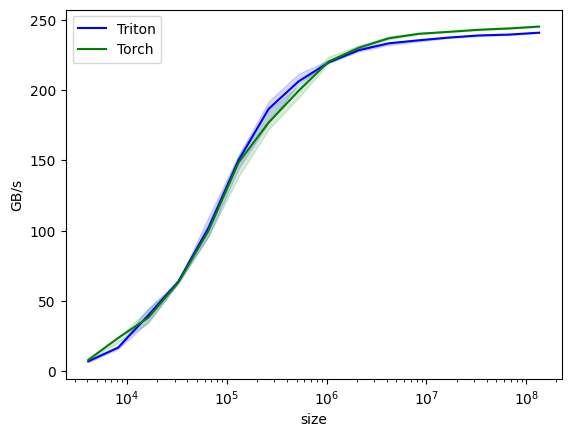

vector-add-performance:
           size      Triton       Torch
0        4096.0    7.078341    8.062992
1        8192.0   16.925620   23.813955
2       16384.0   39.896105   38.161490
3       32768.0   63.999998   63.340208
4       65536.0  101.975103   99.902435
5      131072.0  150.082447  148.495473
6      262144.0  186.712253  176.964903
7      524288.0  206.304306  199.602020
8     1048576.0  219.796534  220.412561
9     2097152.0  228.481122  230.220145
10    4194304.0  233.362608  236.966340
11    8388608.0  235.529197  240.159412
12   16777216.0  237.458234  241.542436
13   33554432.0  238.978065  243.030647
14   67108864.0  239.593512  243.971901
15  134217728.0  240.941748  245.300065


In [31]:
benchmark.run(show_plots=True, print_data=True)